In [161]:
import numpy as np
from PIL import Image
import cv2
import os
from tqdm.notebook import tqdm
import torch
from torchsummaryX import summary as summaryX

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

## UNET from lib segmentation-models-pytorch

In [1]:
!pip install segmentation-models-pytorch

  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=b1e4850665140c0b21af610b1ce68db4343ed49daa5da5eb2674d083dfdaa4c4
  Stored in directory: c:\users\zamarseny\appdata\local\pip\cache\wheels\ed\27\e8\9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12426 sha256=aa1472f2d4c134171d5841710e87cc8d6a8378007e9052a8bb5cb0f890494363
  Stored in directory: c:\users\zamarseny\appdata\local\pip\cache\wheels\90\6b\0c\f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built pretrainedmodels efficientnet-pytorch


In [414]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [415]:
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet34", "imagenet")

## Circles

In [110]:

class BaseDataProvider(object):
    channels = 1
    n_class = 4

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    
    
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [111]:
nx = 512
ny = 512
generator = GrayScaleDataProvider(nx, ny, cnt=10)
#generator = RgbDataProvider(nx, ny, cnt=10)
x_test, y_test = generator(1)

In [112]:
y_test.shape, set(y_test.flatten())

((1, 512, 512, 2), {0.0, 1.0})

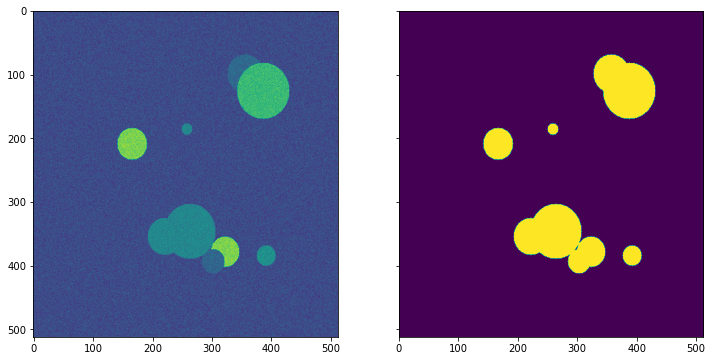

In [113]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,6))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [92]:
y_test[0,...,1].shape, y_test.shape, x_test[0,...,0].shape, x_test.shape

((512, 512), (1, 512, 512, 2), (512, 512), (1, 512, 512, 1))

In [151]:
#Image.fromarray(x_test[0,...,0])
#to_rgb(x_test[0,...,0]).shape, 
pic=to_rgb(x_test[0,...,0])
pic=np.array(pic*255)
pic=pic.astype(int)
#pic=np.transpose(pic, (2, 0,1))
#pic=map(int, pic*255)
print(pic.min(), pic.max(), pic.shape)
pic=Image.fromarray(pic, mode='RGB')
#pic.save('test.jpg')

0 255 (512, 512, 3)


0 255 (512, 512, 3)


True

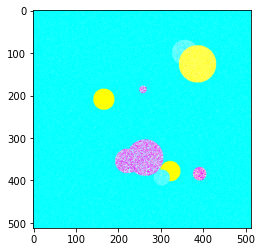

In [157]:
pic=to_rgb(x_test[0,...,0])
pic=np.array(pic*255)
pic=pic.astype(int)
print(pic.min(), pic.max(), pic.shape)
plt.imshow(pic)
#cv2.imwrite('test.jpg', pic)

## Save dataset

In [99]:
num_train=300
num_val=int(num_train/10)
num_test=int(num_train/10)
dataset_lenght={'train': num_train, 'val': num_val, 'test': num_test}
dataset_lenght

{'train': 300, 'val': 30, 'test': 30}

In [281]:
os.mkdir('dataset')
for dataset_part in dataset_lenght.keys():
    os.mkdir('./dataset/'+dataset_part+'/')
    os.mkdir('./dataset/'+dataset_part+'/pics/')
    os.mkdir('./dataset/'+dataset_part+'/labels/')

In [282]:
N=0
for dataset_part in dataset_lenght.keys():
    print(dataset_part, dataset_lenght[dataset_part])
    for num, pic in tqdm(enumerate(range(dataset_lenght[dataset_part]))):
        x_test, y_test = generator(1)
        
        pic=to_rgb(x_test[0,...,0])
        pic=np.array(pic*255)
        pic=pic.astype(int)
        cv2.imwrite('./dataset/'+dataset_part+'/pics/'+str(num)+'.jpg', pic)

        y=torch.tensor(y_test)
        #print(y.shape)
        torch.save(y, './dataset/'+dataset_part+'/labels/'+str(num)+'tensor.pt')
        N+=1

train 300



val 30



test 30


## Run Pretrained Unet on Circles Image

In [93]:
print(x_test.shape)
x_tens=torch.tensor(x_test, dtype=torch.float)
x_tens=x_tens.permute([0,3,1,2])
print(x_tens.size(), x_tens.type())

(1, 512, 512, 1)
torch.Size([1, 1, 512, 512]) torch.FloatTensor


In [94]:
#model(x_tens)
#x_tens = torch.randn(1,1,80,80)#.cuda()
#x_tens = torch.randn(2,1,512,512)
output = model(x_tens)
print(output.shape)

#summaryX(model, (1,32,32))
#model?
#.summary()

torch.Size([1, 3, 512, 512])


In [57]:
#output.min()
output_np=output.detach().numpy()
output_np=np.transpose(output_np, (0, 2,3,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


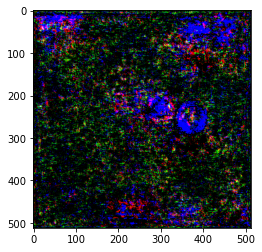

In [58]:
plt.imshow(output_np[0])

In [435]:
summaryX(model, torch.randn(1,3,512,512).cuda())

C:\Users\zamarseny\anaconda3\envs\torch\lib\site-packages\torchsummaryX\torchsummaryX.py:53: RuntimeWarning: overflow encountered in long_scalars
  info["macs"] += int(param.nelement() * np.prod(info["out"][2:]))


                                                        Kernel Shape  \
Layer                                                                  
0_encoder.Conv2d_conv1                                 [3, 64, 7, 7]   
1_encoder.BatchNorm2d_bn1                                       [64]   
2_encoder.ReLU_relu                                                -   
3_encoder.MaxPool2d_maxpool                                        -   
4_encoder.layer1.0.Conv2d_conv1                       [64, 64, 3, 3]   
5_encoder.layer1.0.BatchNorm2d_bn1                              [64]   
6_encoder.layer1.0.ReLU_relu                                       -   
7_encoder.layer1.0.Conv2d_conv2                       [64, 64, 3, 3]   
8_encoder.layer1.0.BatchNorm2d_bn2                              [64]   
9_encoder.layer1.0.ReLU_relu                                       -   
10_encoder.layer1.1.Conv2d_conv1                      [64, 64, 3, 3]   
11_encoder.layer1.1.BatchNorm2d_bn1                             

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder.Conv2d_conv1,"[3, 64, 7, 7]","[1, 64, 256, 256]",9408.0,616562688.0
1_encoder.BatchNorm2d_bn1,[64],"[1, 64, 256, 256]",128.0,64.0
2_encoder.ReLU_relu,-,"[1, 64, 256, 256]",NaN,NaN
3_encoder.MaxPool2d_maxpool,-,"[1, 64, 128, 128]",NaN,NaN
4_encoder.layer1.0.Conv2d_conv1,"[64, 64, 3, 3]","[1, 64, 128, 128]",36864.0,603979776.0
...,...,...,...,...
144_decoder.blocks.4.conv2.ReLU_2,-,"[1, 16, 512, 512]",NaN,NaN
145_decoder.blocks.4.attention2.Identity_attention,-,"[1, 16, 512, 512]",NaN,NaN
146_segmentation_head.Conv2d_0,"[16, 3, 3, 3]","[1, 3, 512, 512]",435.0,113246208.0


## Train

In [284]:
DATA_DIR = './dataset/'

x_train_dir = os.path.join(DATA_DIR, 'train/pics')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'val/pics')
y_valid_dir = os.path.join(DATA_DIR, 'val/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/pics')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

In [285]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [167]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [346]:
class Dataset(BaseDataset):
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['circle', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_dir=images_dir
        self.masks_dir=masks_dir
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #image = cv2.imread(self.images_fps[i])
        image = cv2.imread(self.images_dir+'/'+str(i)+'.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        #mask = cv2.imread(self.masks_fps[i], 0)
        mask = torch.load(self.masks_dir+'/'+str(i)+'tensor.pt')

        

        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        #NEW
        #mask=mask[0,...,0,0]
        mask=mask[0,...,0,:]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

./dataset/train/pics ./dataset/train/labels
(512, 512, 3) (512, 512, 1)
(512, 512, 1)


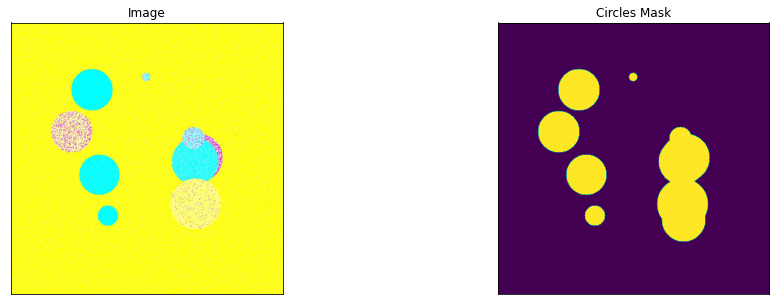

In [382]:
# Lets look at data we have
print(x_train_dir, y_train_dir)
dataset = Dataset(images_dir=x_train_dir, masks_dir=y_train_dir, classes=['circle'])

image, mask = dataset[299] # get some sample
print(image.shape, mask.shape)
#mask=mask[0,...,0,:]
print(mask.shape)
visualize(
    image=image, 
    circles_mask=mask.squeeze(),
)
#cars_mask

In [206]:
import albumentations as albu

In [384]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        """
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        """
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

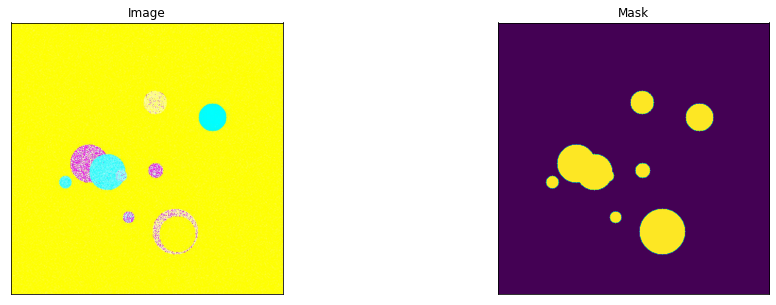

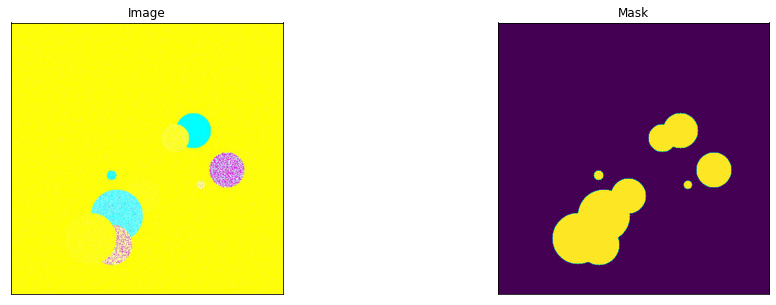

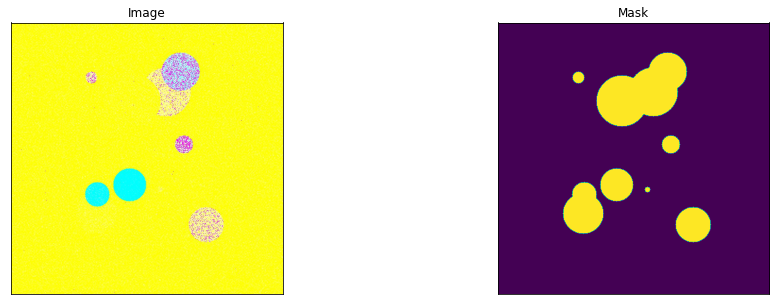

In [408]:
#x_valid_dir, x_test_dir
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(), 
    classes=['circle'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze(-1))

In [416]:
CLASSES=['circle']
DEVICE = 'cuda'
model.to(DEVICE)
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
#get_training_augmentation

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0) # batch_size=8, num_workers=12
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0) # num_workers=4

In [417]:
for x,y in train_loader:
    print(x.shape)
    break

torch.Size([2, 3, 512, 512])


In [418]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [419]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [420]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|████████████████████████████████████| 30/30 [00:03<00:00,  9.82it/s, dice_loss - 3.194, iou_score - 0.3391]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.75it/s, dice_loss - 1.688, iou_score - 0.1026]

Epoch: 2
valid: 100%|███████████████████████████████████| 30/30 [00:02<00:00, 12.89it/s, dice_loss - 0.8349, iou_score - 0.1421]

Epoch: 3
valid: 100%|██████████████████████████████████| 30/30 [00:04<00:00,  7.46it/s, dice_loss - -0.5592, iou_score - 0.2335]

Epoch: 4
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.91it/s, dice_loss - 13.24, iou_score - 0.3805]
Model saved!

Epoch: 5
valid: 100%|█████████████████████████████████████| 30/30 [00:02<00:00, 13.02it/s, dice_loss - 2.57, iou_score - 0.3433]

Epoch: 6
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.78it/s, dice_loss - 7.853, iou_score - 0.2888]

Epoch: 7
valid: 100%|██████████████████████████████████████| 30

valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.70it/s, dice_loss - 4.245, iou_score - 0.2659]

Epoch: 33
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 10.26it/s, dice_loss - 1.016, iou_score - 0.2739]

Epoch: 34
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s, dice_loss - 3.199, iou_score - 0.2285]

Epoch: 35
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.69it/s, dice_loss - 1.063, iou_score - 0.2011]

Epoch: 36
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 13.48it/s, dice_loss - 1.183, iou_score - 0.1543]

Epoch: 37
valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 12.93it/s, dice_loss - -1.19, iou_score - 0.1835]

Epoch: 38
valid: 100%|███████████████████████████████████| 30/30 [00:02<00:00, 12.99it/s, dice_loss - -4.756, iou_score - 0.2923]

Epoch: 39
valid: 100%|███████████████████████████████████| 30/30 [00:02<00:00, 12.75it/s, dic

## Visulize predictions

In [436]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth').eval()

In [421]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0) # num_workers=4

In [439]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|████████████████████████████████████| 30/30 [00:02<00:00, 10.45it/s, dice_loss - 3.748, iou_score - 0.7078]


In [423]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

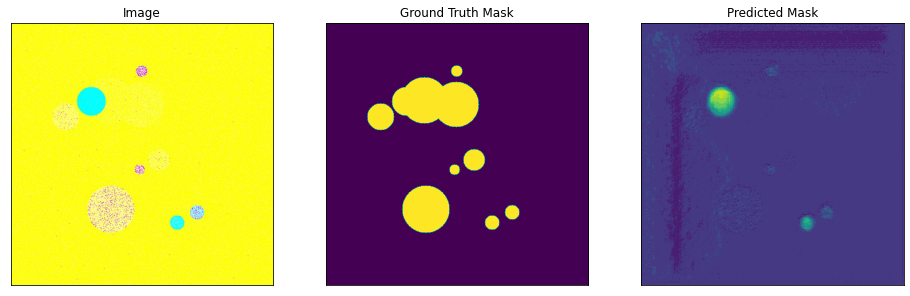

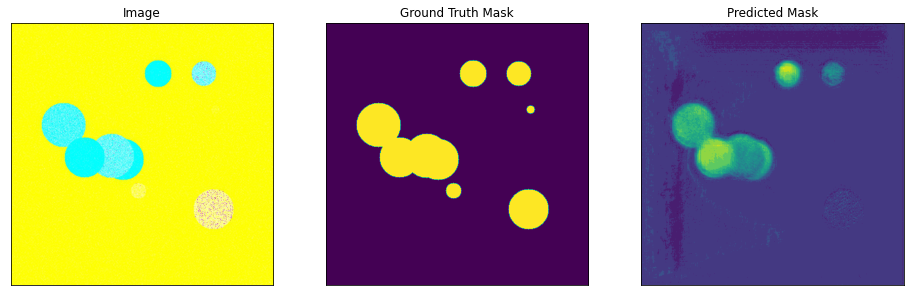

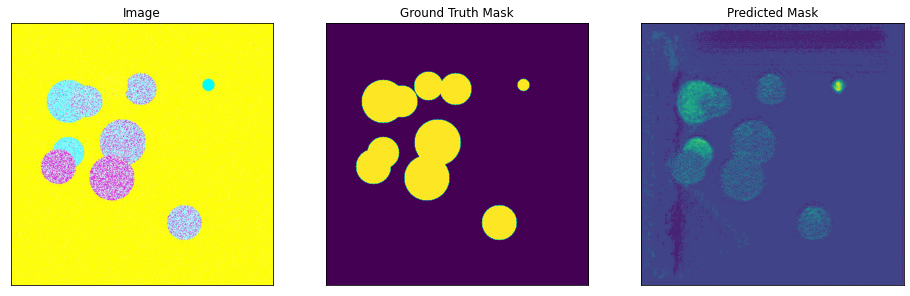

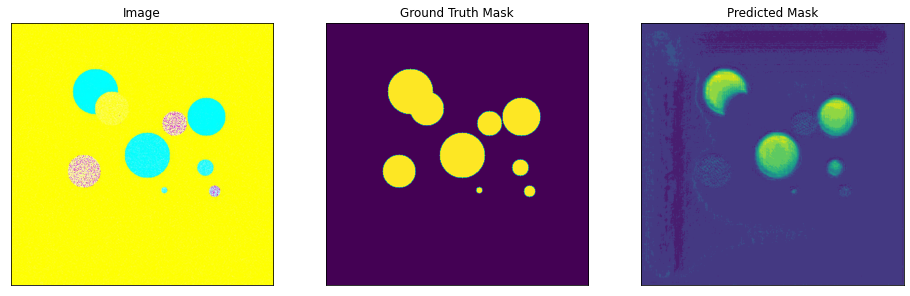

In [437]:
for i in range(4):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask[2,...]
    )

In [ ]:
#Лучше всего определились голубые кружочки
#В целом iou_score - 0.7078 - не плохо
#Для улучшения можно увеличить обучающую выборку и довести до ума аугументации.
#Конец решения.